[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb)

# GPT-4o Research Agent in LangGraph

**Research agents** are multi-step LLM agents that through multiple steps can produce in depth research reports on a topic of our choosing. Most research agents are packed up into their own frameworks, like BlockAGI and others.

In this example, we want to demonstrate how we can build our own AI research agent using `gpt-4o`, Pinecone, LangGraph, arXiv, and Google via the SerpAPI.

In [2]:
# !apt-get install graphviz libgraphviz-dev pkg-config

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4 pkg-config
0 upgraded, 10 newly installed, 2 to remove and 49 not upgraded.
Need to get 2,482 kB of archives.
After this operation, 7,670 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config a

We need these prerequisite libraries to run a graph visualization library (`pygraphviz`). We will use this library during this notebook to understand the structure of our graphs _but_ it is not required to use `langgraph`.

Now we install Python libraries:

In [3]:
# !pip install -qU \
#     datasets==2.19.1 \
#     langchain-pinecone==0.1.1 \
#     langchain-openai==0.1.9 \
#     langchain==0.2.5 \
#     langchain-core==0.2.9 \
#     langgraph==0.1.1 \
#     semantic-router==0.0.48 \
#     serpapi==0.1.5 \
#     google-search-results==2.4.2 \
#     pygraphviz==1.12  # for visualizing

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

## Research Agent Overview

Our research agent will consist of a function calling AI agent that has access to several tools that it can use to find information on a particular topic. It will be able to use several tools over multiple steps, meaning it can find information on one topic, broaden the scope of knowledge on this topic and _even_ investigate parallel topics where relevant.

The tools we will be using are:

* **ArXiv paper fetch**: Given an arXiv paper ID, this tool provides our agent with the abstract of the paper.
* **Web search**: This tool provides our agent with access to Google search for more generalized queries.
* **RAG search**: We will create a knowledge base containing AI arXiv papers. This tool provides our agent with access to this knowledge.
* **RAG search with filter**: Sometimes our agent may need more information from a specific paper, this tool allows our agent to do just that.
* **Final answer**: We create a custom final answer tool that forces our agent to output information in a specific format like:

```
INTRODUCTION
------------
<some intro to our report>

RESEARCH STEPS
--------------
<the steps the agent took during research>

REPORT
------
<the report main body>

CONCLUSION
----------
<the report conclusion>

SOURCES
-------
<any sources the agent used>
```

## Setup Knowledge Base

We'll be running our agent against a knowledge base — which requires a Pinecone index to be built.

You can, if needed, skip this step and replace the `search` tool with a placeholder value if wanting to quickly test the structure of a RAG agent _without_ the RAG.

If you want full functionality here, you do need to run this section — but we'll make it quick.

### Download a Dataset

In [4]:
# !pip install vanna
# !pip install python-dotenv
# !pip install anthropic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 50.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.2/198.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.0 MB/s eta 0:00:00
  Created wheel for flasgger: filename=flasgger-0.9.7.1-py2.py3-none-any.whl size=3865183 sha256=c29276eeddfa5294dffa5986caf5630fbf020b23ccafbc548bb7cf9794206895
  Stored in directory: /root/.cache/pip/wheels/92/c0/ec/a7935834b3205c0c0acbd4ba52b9c8215835984fe168374262
Successfully built flasgger
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.9/891.9 kB 16.4 MB/s eta 0:00:00


In [8]:
import ast
import logging
import os
import random
from typing import Dict, List, Tuple, Optional

import ray
from dotenv import load_dotenv
import requests
from rich import print
from numpy import dot
from copy import deepcopy
import json

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# load_dotenv("/Users/srikaranhc/Documents/Hayagriva/Projects/web_scrapper/llmapps/support_haystack/.env")

## references
# https://medium.com/@nickprock/how-to-develop-your-hyde-reranker-in-haystack-52a34c2ea03f

In [7]:
# !pip install python-dotenv
# !pip install pypdf
# !pip install mdit-plain

# !pip install sentence-transformers
# !pip install "haystack-ai>=2.3.1"
# !pip install "qdrant-haystack>=4.1.2"
# !pip install "anthropic-haystack>=1.0.0"

# !pip install ray

In [9]:

import ast
import logging
import os
import random
from typing import Dict, List, Tuple, Optional

import ray
from dotenv import load_dotenv
import requests
from rich import print
from haystack.components.converters import MarkdownToDocument, PyPDFToDocument, TextFileToDocument
from haystack import Document
from numpy import dot
from copy import deepcopy
import json

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

load_dotenv("/Users/srikaranhc/Documents/Hayagriva/Projects/web_scrapper/llmapps/support_haystack/.env")

## references
# https://medium.com/@nickprock/how-to-develop-your-hyde-reranker-in-haystack-52a34c2ea03f

False

In [10]:
class JinaScraper:
    def __init__(self, api_keys: List[str]):
        self.api_keys = api_keys

        logger.info("JinaScraper initialized with %d API keys", len(api_keys))

    def scrape_jina_ai(self, url: str, api_key: str) -> Tuple[str, int]:
        """Perform the GET request to the Jina AI endpoint with the given API key."""
        headers = {
            "Authorization": api_key,
            "X-With-Links-Summary": "true",
            "X-With-Generated-Alt": "true",
            "Accept": "application/json",
            "X-No-Cache": "true",
        }
        logger.debug("Requesting URL: %s with API key", url)
        response = requests.get(f"https://r.jina.ai/{url}", headers=headers)
        logger.debug("Response status code: %d", response.status_code)
        return response.text, response.status_code


def get_api_key(index: int, api_keys: List[str]) -> str:
    """Rotate API keys based on index in a random order."""
    shuffled_keys = api_keys[:]  # Create a copy of the original list to avoid modifying it
    random.shuffle(shuffled_keys)  # Shuffle the keys in a random order
    return shuffled_keys[index % len(api_keys)]


@ray.remote
def process_url(url: str, api_keys: List[str], retries: int, data_dir: str, save_markdown: bool) -> Dict[str, str]:
    """Process a URL with retry logic and API key rotation."""
    scraper = JinaScraper(api_keys)

    for attempt in range(retries):
        api_key = get_api_key(attempt, api_keys)
        try:
            logger.info("Processing URL: %s (Attempt %d)", url, attempt + 1)
            extracted_text, status = scraper.scrape_jina_ai(url, api_key)
            if status == 200:
                logger.info("Successfully processed URL: %s", url)

                if save_markdown:
                    file_name = os.path.join(data_dir, f"{url.replace('https://', '').replace('/', '_')}.md")
                    with open(file_name, "w", encoding="utf-8") as file:
                        file.write(f"# {url}\n\n{ast.literal_eval(extracted_text)['data']['content']}")
                        logger.info("Saved scraped data to %s", file_name)

                return {"url": url, "extracted_text": extracted_text, "status": status}
            else:
                logger.warning("Error %d for URL %s on attempt %d", status, url, attempt + 1)

        except Exception as e:
            logger.exception("Exception for URL %s on attempt %d: %s", url, attempt + 1, str(e))

    logger.error("Failed to process URL: %s after %d attempts", url, retries)
    return {"url": url, "extracted_text": "", "status": "Failed after retries"}


api_keys = [
        "jina_152cc39b6f2a41fda96c893d49ecd0393H04ZFbCfWnFUeGBtqxumZ8sraIS",
        "jina_c21c4873d92f4a83af9f9cc273edbc32KnAKpU-nFeG14LV9A_ZQ_kHMNK8c",
        "jina_22332dbfeb32468a90064c6e4d5ea9f13mQ5W-IhIcqkgrRg98wS1GVC5HmP",
        "jina_c11d793171964a00bbd9a80102412a5ebT66ul-PfqP5yf8Zb36pdLQGGi3K",
        "jina_5753e10d4e9c4a6998a606025230629dTDvSkURYLnDkEnKmSUEjLPlCm4Ms",
        "jina_627427e380974061ab2e4a17b89436be-NCGFuvJriAKobmPRCEQupyecILb",
    ]

try:# Configuration
    ray.init(ignore_reinit_error=True)
    save_markdown = True
    data_dir = "./webscraped_data"
    os.makedirs(data_dir, exist_ok=True)
    retries = 3
    url_list = [
        "https://helpdesk.revelator.com/support/solutions/articles/69000808652-faq-revenue-report-processing",
        "https://helpdesk.revelator.com/support/solutions/articles/69000808409-faq-frequently-asked-questions",
        "https://helpdesk.revelator.com/support/solutions/articles/69000819271-filing-a-dmca-counter-notification",
        "https://helpdesk.revelator.com/support/solutions/articles/69000826010-what-revenue-channels-are-included-in-revenue-analytics",
        "https://helpdesk.revelator.com/support/solutions/articles/69000808415-connecting-your-digital-supply-chain",
        "https://helpdesk.revelator.com/support/solutions/articles/69000854401-metadata-best-practices-apple-music-style-guide-2-2",
        "https://helpdesk.revelator.com/support/solutions/articles/69000808411-faq-distribution",
        "https://helpdesk.revelator.com/support/solutions/articles/69000842837-spotify-discovery-mode",
        "https://helpdesk.revelator.com/support/solutions/articles/69000833730-migration-process-and-expected-timeline",
        "https://helpdesk.revelator.com/support/solutions/articles/69000825506-what-music-genres-does-revelator-support-",
        "https://helpdesk.revelator.com/support/solutions/articles/69000808404-which-digital-service-providers-dsps-does-revelator-support-",
        "https://help.apple.com/pdf/applestyleguide/en_US/apple-style-guide.pdf",
        "https://assets.ctfassets.net/jtdj514wr91r/2MCgL0vUEcl8MJijHPcLG1/17e8114c81872a85a34dca6b9f4e5f41/Spotify_Music_Metadata_Style_Guide_V2.2.0.pdf"

    ]

    # Scrape the URLs using Ray
    results = ray.get([process_url.remote(url, api_keys, retries, data_dir, save_markdown) for url in url_list])
    # print(results)
    logger.info("Processed %d URLs", len(results))
except Exception as e:
    logger.exception("Exception during scraping: %s", str(e))

finally:
    ray.shutdown()
# logger.debug("Requesting URL: %s with API key", main_url)
# response = requests.get(f"https://r.jina.ai/{main_url}")

2024-09-16 09:51:27,638	INFO worker.py:1783 -- Started a local Ray instance.
(process_url pid=5019) Error 402 for URL https://helpdesk.revelator.com/support/solutions/articles/69000808409-faq-frequently-asked-questions on attempt 1
(process_url pid=5020) Failed to process URL: https://helpdesk.revelator.com/support/solutions/articles/69000808652-faq-revenue-report-processing after 3 attempts
(process_url pid=5019) Error 402 for URL https://helpdesk.revelator.com/support/solutions/articles/69000808404-which-digital-service-providers-dsps-does-revelator-support- on attempt 1 [repeated 12x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(process_url pid=5019) Failed to process URL: https://helpdesk.revelator.com/support/solutions/articles/69000854401-metadata-best-practices-apple-music-style-guide-2-2 after 3 a

In [11]:
# print(response.content)

Building a knowledge base:

In [12]:
from haystack.components.writers import DocumentWriter
from haystack.components.converters import MarkdownToDocument, PyPDFToDocument, TextFileToDocument
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.routers import FileTypeRouter
from haystack.components.joiners import DocumentJoiner
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from pathlib import Path


def load_index_doc(output_dir):
    document_store = InMemoryDocumentStore()
    file_type_router = FileTypeRouter(mime_types=["text/plain", "application/pdf", "text/markdown"])
    text_file_converter = TextFileToDocument()
    markdown_converter = MarkdownToDocument()
    pdf_converter = PyPDFToDocument()
    document_joiner = DocumentJoiner()

    document_cleaner = DocumentCleaner()
    document_splitter = DocumentSplitter(split_by="word", split_length=150, split_overlap=50)

    document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
    document_writer = DocumentWriter(document_store)

    preprocessing_pipeline = Pipeline()
    preprocessing_pipeline.add_component(instance=file_type_router, name="file_type_router")
    preprocessing_pipeline.add_component(instance=text_file_converter, name="text_file_converter")
    preprocessing_pipeline.add_component(instance=markdown_converter, name="markdown_converter")
    preprocessing_pipeline.add_component(instance=pdf_converter, name="pypdf_converter")
    preprocessing_pipeline.add_component(instance=document_joiner, name="document_joiner")
    preprocessing_pipeline.add_component(instance=document_cleaner, name="document_cleaner")
    preprocessing_pipeline.add_component(instance=document_splitter, name="document_splitter")
    preprocessing_pipeline.add_component(instance=document_embedder, name="document_embedder")
    preprocessing_pipeline.add_component(instance=document_writer, name="document_writer")

    preprocessing_pipeline.connect("file_type_router.text/plain", "text_file_converter.sources")
    preprocessing_pipeline.connect("file_type_router.application/pdf", "pypdf_converter.sources")
    preprocessing_pipeline.connect("file_type_router.text/markdown", "markdown_converter.sources")
    preprocessing_pipeline.connect("text_file_converter", "document_joiner")
    preprocessing_pipeline.connect("pypdf_converter", "document_joiner")
    preprocessing_pipeline.connect("markdown_converter", "document_joiner")
    preprocessing_pipeline.connect("document_joiner", "document_cleaner")
    preprocessing_pipeline.connect("document_cleaner", "document_splitter")
    preprocessing_pipeline.connect("document_splitter", "document_embedder")
    preprocessing_pipeline.connect("document_embedder", "document_writer")


    preprocessing_pipeline.run({"file_type_router": {"sources": list(Path(output_dir).glob("**/*"))}})

    return document_store

In [13]:
webscrapped_data_path = "/content/webscraped_data"
document_store = load_index_doc(webscrapped_data_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Converting markdown files to Documents: 100%|██████████| 9/9 [00:00<00:00, 48.70it/s]


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
document_store.filter_documents()[:5]

[Document(id=258169da30c87a98db8d4e41a7555a3bd999dbc2f1ab118f460b233912a473b6, content: 'https://helpdesk.revelator.com/support/solutions/articles/69000808415-connecting-your-digital-supply...', meta: {'file_path': '/content/webscraped_data/helpdesk.revelator.com_support_solutions_articles_69000808415-connecting-your-digital-supply-chain.md', 'source_id': '97a4db7443df527d4c975f67a37a0d8f83e1e3f1293a0db92b6ff318d6f5020e', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0, '_split_overlap': [{'doc_id': '401d0d5df045a63f1ac1c3c5dd89f94131f7445f5f8e9e2aa6a6956e6e1cfcf4', 'range': (0, 282)}]}, embedding: vector of size 384),
 Document(id=401d0d5df045a63f1ac1c3c5dd89f94131f7445f5f8e9e2aa6a6956e6e1cfcf4, content: 'Name and Licensor ID
 If you are using Revelator to distribute your music to DSPs, just let us know w...', meta: {'file_path': '/content/webscraped_data/helpdesk.revelator.com_support_solutions_articles_69000808415-connecting-your-digital-supply-chain.md', 'source_id': '97a4db7

In [15]:
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.generators import OpenAIGenerator
from haystack.components.builders import PromptBuilder
from haystack import Pipeline


retriever = InMemoryBM25Retriever(document_store, top_k=3)

In [16]:
retriever.run("this is it")

{'documents': [Document(id=96b4045d028f7c9b067a700ff2a25a52b06217f600514407b38179af96908539, content: 'new releases? Delivery time to most major DSPs is within a few hours / same day. Why does it show li...', meta: {'file_path': '/content/webscraped_data/helpdesk.revelator.com_support_solutions_articles_69000808409-faq-frequently-asked-questions.md', 'source_id': 'ea9fdb8d5058e9f0b6f4085e6bfce60ab7ea610acd46e224179f0a0edb0fe3db', 'page_number': 1, 'split_id': 6, 'split_idx_start': 3678, '_split_overlap': [{'doc_id': 'fa593efc682144642446bee9d5c6cb75b196b0551db931f78b6fe3ced1cf59a3', 'range': (569, 823)}, {'doc_id': '1ff3eb7a1bf66f71cddaf377e62c41017656b45815b9d6473bd57fd2215ede0c', 'range': (0, 315)}]}, score: 3.478163225637048, embedding: vector of size 384),
  Document(id=9a0c48ce879147bf2f420b873d4b1e77c068607eafd5b86328b38878b90b2ead, content: 'IDs are required
  Provide migration instructions by filling out our Client Migration Worksheet****.
  R...', meta: {'file_path': '/content

Populate our knowledge base:

## Graph State

We will define a custom graph state to support our agent-oriented decision making.

In [17]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

There are four parts to our agent state, those are:

* `input`: this is the user's most recent query, usually this would be a question that we want to answer with our research agent.
* `chat_history`: we are building a conversational agent that can support multiple interactions, to allow previous interactions to provide additional context throughout our agent logic we include the chat history in the agent state.
* `intermediate_steps`: provides a record of all steps the research agent will take between the user asking a question via `input` and the agent providing a final answer. This can include things like "search arxiv", "perform general purpose web search", etc. These intermediate steps are crucial to allowing the agent to follow a path of coherent actions and ultimately producing an informed final answer.

## Custom Tools

We will define several tools for this agent that will focus on initial data discovery, that will allow the LLM to use more tools to research more deeply via a variety of different routes.

### ArXiv Paper Fetch

The `fetch_arxiv` tool will allow our agent to get the summary of a specific paper given an ArXiv paper ID. To do this, we will simply send a GET request to arXiv and use regex to extract the paper abstract.

In [18]:
import requests

# we will test with the mixtral paper
arxiv_id = "2401.04088"

res = requests.get(
    f"https://export.arxiv.org/abs/{arxiv_id}"
)
res.text

'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" lang="en">\n<head>\n<title>[2401.04088] Mixtral of Experts</title>\n<link rel="shortcut icon" href="/favicon.ico" type="image/x-icon" />\n<link rel="stylesheet" type="text/css" media="screen" href="/css/arXiv-export.css" />\n<link rel="stylesheet" type="text/css" media="screen" href="/bibex/bibex.css?20181009">\n<link rel="stylesheet" type="text/css" media="screen" href="https://static.arxiv.org/static/browse/0.3.8/css/browse_search.css" />\n<meta name="citation_title" content="Mixtral of Experts" />\n<meta name="citation_author" content="Jiang, Albert Q." />\n<meta name="citation_author" content="Sablayrolles, Alexandre" />\n<meta name="citation_author" content="Roux, Antoine" />\n<meta name="citation_author" content="Mensch, Arthur" />\n<meta name="citation_author" content="Savary

There's a lot going on there. Fortunately, we can use some _relatively_ straightforward regex to find the paper abstract.

In [19]:
import re

# our regex
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

# we search
re_match = abstract_pattern.search(res.text)

# and now let's see what we got
print(re_match.group(1))

We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.
Mixtral has the same architecture as Mistral 7B, with the difference that each
layer is composed of 8 feedforward blocks (i.e. experts). For every token, at
each layer, a router network selects two experts to process the current state
and combine their outputs. Even though each token only sees two experts, the
selected experts can be different at each timestep. As a result, each token has
access to 47B parameters, but only uses 13B active parameters during inference.
Mixtral was trained with a context size of 32k tokens and it outperforms or
matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,
Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and
multilingual benchmarks. We also provide a model fine-tuned to follow
instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,
Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both
the base and instruct models are released under the Apache 2.0 license.

Now we pack all of this logic into a tool for our agent to use.

In [20]:
from langchain_core.tools import tool


@tool("fetch_arxiv")
def fetch_arxiv(arxiv_id: str):
    """Gets the abstract from an ArXiv paper given the arxiv ID. Useful for
    finding high-level context about a specific paper."""
    # get paper page in html
    res = requests.get(
        f"https://export.arxiv.org/abs/{arxiv_id}"
    )
    # search html for abstract
    re_match = abstract_pattern.search(res.text)
    # return abstract text
    return re_match.group(1)

Let's test the tool.

In [21]:
print(
    fetch_arxiv.invoke(input={"arxiv_id": arxiv_id})
)

We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.
Mixtral has the same architecture as Mistral 7B, with the difference that each
layer is composed of 8 feedforward blocks (i.e. experts). For every token, at
each layer, a router network selects two experts to process the current state
and combine their outputs. Even though each token only sees two experts, the
selected experts can be different at each timestep. As a result, each token has
access to 47B parameters, but only uses 13B active parameters during inference.
Mixtral was trained with a context size of 32k tokens and it outperforms or
matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,
Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and
multilingual benchmarks. We also provide a model fine-tuned to follow
instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,
Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both
the base and instruct models are released under the Apache 2.0 license.

### Web Search

The web search tool will provide the agent with access to web search. It will be instructed to use this for more general knowledge queries.

In [24]:
from getpass import getpass
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass("OpenAI API key: ")



OpenAI API key: ··········


In [25]:
from serpapi import GoogleSearch

serpapi_params = {
    "engine": "google",
    "api_key": os.getenv("SERPAPI_KEY") or getpass("SerpAPI key: ")
}

search = GoogleSearch({
    **serpapi_params,
    "q": "coffee"
})

results = search.get_dict()["organic_results"]

SerpAPI key: ··········


In [26]:
contexts = "\n---\n".join(
    ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
)

In [27]:
print(contexts)

Coffee
Coffee is a beverage brewed from roasted coffee beans. Darkly colored, bitter, and slightly acidic, coffee has a 
stimulating effect on humans, primarily due ...
https://en.wikipedia.org/wiki/Coffee
---
Blue Bottle Coffee | Fresh Roasted Specialty Coffee
Blue Bottle Coffee is a specialty coffee roaster with cafes in LA, SF, NYC, & Japan. Shop our freshly roasted 
specialty coffee online & in-store.
https://bluebottlecoffee.com/?srsltid=AfmBOoppt4w_KykJcEUpyZkTMVMhXfDFLbc5YaWzBiR55fwrwdWd-7uy
---
Peet's Coffee | The Original Craft Coffee, Est. 1966
Since 1966, Peet's Coffee has sourced and offered superior coffees and teas and adhering to strict high-quality and
taste standards. Shop today.
https://www.peets.com/
---
Starbucks Coffee Company
More than just great coffee. Explore the menu, sign up for Starbucks® Rewards, manage your gift card and more.
https://www.starbucks.com/
---
The Coffee Bean & Tea Leaf | CBTL
We're passionate about delivering the best handcrafted products and take pride in the journey from seed to cup.
https://coffeebean.com/
---
Madcap Coffee Company - Grand Rapids
Madcap Coffee's mission has been to unveil the inspiring craftsmanship and human touch in every cup of specialty 
coffee, transforming an ordinary daily ...
https://www.madcapcoffee.com/
---
What is Coffee?
Coffee traces its origin to a genus of plants known as Coffea. Within the genus there are over 500 genera and 6,000
species of tropical trees and shrubs.
https://www.ncausa.org/About-Coffee/What-is-Coffee
---
Blanchard's Coffee Roasting Company
Enjoy your coffee outside! Each of our cafes offer a patio to enjoy your coffee under the sun with friends. Plan 
Your Visit.
https://blanchardscoffee.com/?srsltid=AfmBOorVEjEtEcbAo3tm9wtkrhxQzqv8iqgarBHXDCiiQJL37-tahFyb

We put this process into a tool:

In [28]:
@tool("web_search")
def web_search(query: str):
    """Finds general knowledge information using Google search. Can also be used
    to augment more 'general' knowledge to a previous specialist query."""
    search = GoogleSearch({
        **serpapi_params,
        "q": query,
        "num": 5
    })
    results = search.get_dict()["organic_results"]
    contexts = "\n---\n".join(
        ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
    )
    return contexts

In [29]:

res = retriever.run("this is it")

In [30]:
res["documents"][0].content,res["documents"][0].id

('new releases? Delivery time to most major DSPs is within a few hours / same day. Why does it show live on the UI when it is not live yet on YT, Yandex, iMusica and Nuuday and Shazam? Live on the UI for the following DSPs YouTube, Yandex, iMusica, Nuuday and Shazam simply means that they have confirmed ingestion. Why is it live on Shazam before the release date? This is just how Shazam works: they don’t respect release dates. But you can’t play the song yet… If you don’t want it to appear at all before the release date, do not send it to Shazam before that date. Which DSPs do you have an integration to automatically import revenue reports? Amazon Deezer iTunes/Apple Music Spotify All Merlin reports Does Revelator support reporting for physical revenue? We do support physical if the following criteria is met: If the customer uses ',
 '96b4045d028f7c9b067a700ff2a25a52b06217f600514407b38179af96908539')

### RAG Tools

We provide two RAG-focused tools for our agent. The `rag_search` allows the agent to perform a simple RAG search for some information across _all_ indexed research papers. The `rag_search_filter` also searches, but _within_ a specific paper which is filtered for via the `arxiv_id` parameter.

We also define the `format_rag_contexts` function to handle the transformation of our Pinecone results from a JSON object to a readble plaintext format.

In [60]:

from langchain_core.tools import tool

def format_rag_contexts(matches: dict):
    contexts = []
    for x in matches["documents"]:
        text = (
            f"""Content: {x.content}\n"
            f"Id: {x.id}\n" """

        )
        contexts.append(text)
    context_str = "\n---\n".join(contexts)
    return context_str

@tool("rag_search")
def rag_search(query: str):
    """Finds specialist information on AI using a natural language query."""
    matches = retriever.run(query)
    context_str = format_rag_contexts(matches)
    return context_str

In [61]:
# from langchain_core.tools import tool

# def format_rag_contexts(matches: list):
#     contexts = []
#     for x in matches:
#         text = (
#             f"Title: {x['metadata']['title']}\n"
#             f"Content: {x['metadata']['content']}\n"
#             f"ArXiv ID: {x['metadata']['arxiv_id']}\n"
#             f"Related Papers: {x['metadata']['references']}\n"
#         )
#         contexts.append(text)
#     context_str = "\n---\n".join(contexts)
#     return context_str

# @tool("rag_search_filter")
# def rag_search_filter(query: str, arxiv_id: str):
#     """Finds information from our ArXiv database using a natural language query
#     and a specific ArXiv ID. Allows us to learn more details about a specific paper."""
#     xq = encoder([query])
#     xc = index.query(vector=xq, top_k=6, include_metadata=True, filter={"arxiv_id": arxiv_id})
#     context_str = format_rag_contexts(xc["matches"])
#     return context_str

# @tool("rag_search")
# def rag_search(query: str):
#     """Finds specialist information on AI using a natural language query."""
#     xq = encoder([query])
#     xc = index.query(vector=xq, top_k=2, include_metadata=True)
#     context_str = format_rag_contexts(xc["matches"])
#     return context_str

### Final Answer

Finally, we define a "final answer" tool. This isn't a tool in the usual sense, instead we use it to force a particular output format from our LLM via the function/tool calling.

In [62]:
@tool("final_answer")
def final_answer(
    introduction: str,
    answer: str
):
    """Returns a natural language response to the user in the form of a research
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the user's question and the
    and about the answer
    - `answer`: answer to the question from the user
    """
    if type(introduction) is list:
        introduction = "\n".join([f"- {r}" for r in introduction])
    if type(answer) is list:
        answer = "\n".join([f"- {s}" for s in answer])
    return ""

## Initialize the "Oracle"

The **Oracle** LLM is our graph's decision maker. It decides which path we should take down our graph. It functions similarly to an agent but is much simpler and reliable.

The Oracle consists of an LLM provided with a set of potential function calls (ie our tools) that it can decide to use — we force it to use _at least_ one of those tool using the `tool_choice="any"` setting (see below). Our Oracle only makes the decision to use a tool, it doesn't execute the tool code itself (we do that seperately in our graph).

### Oracle Prompt

Our prompt for the Oracle will emphasize it's decision making ability within the `system_prompt`, leave a placeholder for us to later insert `chat_history`, and provide a place for us to insert the user `input`.

In [63]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

Next, we must initialize our `llm` (for this we use `gpt-4o`) and then create the _runnable_ pipeline of our Oracle.

The runnable connects our inputs (the user `input` and `chat_history`) to our `prompt`, and our `prompt` to our `llm`. It is also where we _bind_ our tools to the LLM and enforce function calling via `tool_choice="any"`.

In [64]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0
)

tools=[
    rag_search,
    fetch_arxiv,
    web_search,
    final_answer
]

# define a function to transform intermediate_steps from list
# of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

Test the agent quickly to confirm it is functional:

In [65]:
inputs = {
    "input": "what is dsp",
    "chat_history": [],
    "intermediate_steps": [],
}
out = oracle.invoke(inputs)
out

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8iXk2j4cboP0DWqnSZgalPLf', 'function': {'arguments': '{"query": "What is DSP?"}', 'name': 'rag_search'}, 'type': 'function'}, {'id': 'call_JPvJ5ewGuH9QFJUiA1Pbn0nR', 'function': {'arguments': '{"query": "What is DSP?"}', 'name': 'web_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 375, 'total_tokens': 424, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'stop', 'logprobs': None}, id='run-93346483-af2a-4bbe-be19-b544bd6c7271-0', tool_calls=[{'name': 'rag_search', 'args': {'query': 'What is DSP?'}, 'id': 'call_8iXk2j4cboP0DWqnSZgalPLf'}, {'name': 'web_search', 'args': {'query': 'What is DSP?'}, 'id': 'call_JPvJ5ewGuH9QFJUiA1Pbn0nR'}], usage_metadata={'input_tokens': 375, 'output_tokens': 49, 'total_tokens': 424})

It is running but we are returning a lot of output here, we can narrow this down to what we need — ie, the chosen tool name and generated input args for the tool.

In [66]:
out.tool_calls[0]["name"]

'rag_search'

In [67]:
out.tool_calls[0]["args"]

{'query': 'What is DSP?'}

We can see now that our Oracle decided to use the `web_search` tool with a `query` of `"interesting facts about dogs"` — a good choice.

## Define Nodes for Graph

We will be passing the tool use decision to our `router` which will _route_ the output to the chosen node component to run (we define these below) based on the `out.tool_calls[0]["name"]` value.

In [68]:
def run_oracle(state: list):
    print("run_oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"

All of our tools can be run using the same function logic, which we define with `run_tool`. The input parameters to our tool call and the resultant output are added to our graph state's `intermediate_steps` parameter.

In [69]:
tool_str_to_func = {

    "rag_search": rag_search,
    "fetch_arxiv": fetch_arxiv,
    "web_search": web_search,
    "final_answer": final_answer
}

def run_tool(state: list):
    # use this as helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}

## Define Graph

In [70]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("rag_search", run_tool)
graph.add_node("fetch_arxiv", run_tool)
graph.add_node("web_search", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

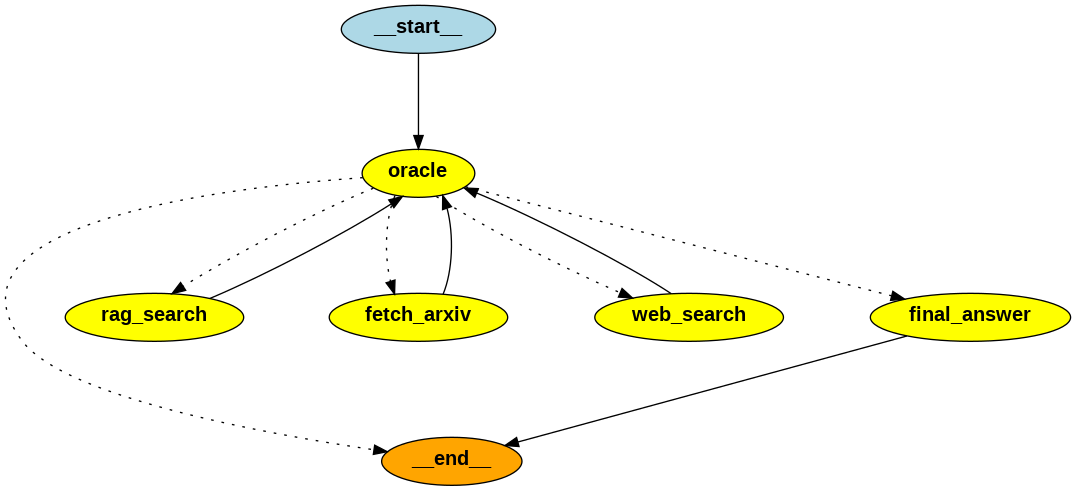

In [71]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

## Building Reports

Let's test our research agent. First, I want to try on something simple (although not within the intended use-case of our agent):

In [72]:
out = runnable.invoke({
    "input": "what is dsp",
    "chat_history": [],
})

run_oracle

intermediate_steps: []

rag_search.invoke(input={'query': 'What is DSP?'})

run_oracle

intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'What is DSP?'}, log='TBD'), 
AgentAction(tool='rag_search', tool_input={'query': 'What is DSP?'}, log='Content: 
https://helpdesk.revelator.com/support/solutions/articles/69000825506-what-music-genres-does-revelator-support- 
What music genres does Revelator support? Print Modified on: Fri, 14 Oct, 2022 at 12:33 PM At of October 14, 2022 
Revelator supports the music genres listed below. Please note: These genres are the ones supported by the majority 
of DSPs with very few exceptions (most notably from DSPs specializing in a certain genre such as Beatport). If you 
were to use another genre, the DSP would likely remap it to one of these.\nThis list may not be up to date by the 
time you read this. Please review the options available to you when creating a track/release in your Revelator 
dashboard. PARENT GENRE GENRE African African African African African African African African African African 
African African African African African African African African Alternative Alternative Alternative Alternative 
Alternative Alternative Alternative Alternative Alternative Arabic Arabic Arabic Arabic Blues Blues Blues Blues 
Blues Blues Blues Brazilian Brazilian Brazilian Brazilian Brazilian Brazilian \n"\n            f"Id: 
07f2211351d6c1ae12428a36fdb0cf1561172ec8dbc67e935f8314ec91b9abf8\n" \n---\nContent: ingested, whether you are using
Revelator Pro to distribute, do reporting, and/or royalties. This can be done in a few different ways: Your current
aggregator can possibly set up a feed to Revelator. Use Revelator\'s catalog ingestion template. Create a release 
directly on the platform. What happens to my chart history/rankings, playlist placement, etc when transferring 
distribution to Revelator? When migrating catalogs, the only major DSP that loses some historical data/rankings is 
iTunes/Apple Music. If the UPC-ISRCs remain the same, the merge should be complete and chart history & popularity 
should be retained but ratings & reviews will be lost. For other DSPs, as long as UPC-ISRCs are all the same (and 
in the case of Spotify, you also need the track length and version info to be the same); all ‘ranking’ is 
preserved. How can I import historical reporting/revenue/statements? Revelator can import old revenue using reports
(those that we \n"\n            f"Id: 56cd0a380f60aeb01503476a2a320fcff063acad45668e00ec63facad663762e\n" 
\n---\nContent: does Revelator provide Trends for? iTunes iTunes Match Apple Music Spotify Deezer Amazon Soundcloud
YouTube, UMA and Pandora are next to be integrated. What does the onboarding process look like? Our customers work 
with someone from our Customer Ops team to create their account, provide the ingestion & migration forms, and walk 
you through the process. What is Revelator\'s protocol in case of technical difficulties with the platform? We have
a support team that works with you. Response time is generally within 24 hours of email. Do you provide phone 
support? Live chat? Support is available via email. Phone support is available upon request when the issue cannot 
be resolved over email. Where is Revelator based? Distribution and Platform Services (reporting, royalties and 
payments) are managed by our US corporation and software/platform development and R&D are managed by our Israel 
corporation. What is PayPal\'s fee structure when using the integration \n"\n            f"Id: 
21b3350eab969bd8b38160f4acfdb4184c43b8c4d590730b42c3439650799c7f\n" ')]

web_search.invoke(input={'query': 'What is DSP?'})

run_oracle

intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'What is DSP?'}, log='TBD'), 
AgentAction(tool='rag_search', tool_input={'query': 'What is DSP?'}, log='Content: 
https://helpdesk.revelator.com/support/solutions/articles/69000825506-what-music-genres-does-revelator-support- 
What music genres does Revelator support? Print Modified on: Fri, 14 Oct, 2022 at 12:33 PM At of October 14, 2022 
Revelator supports the music genres listed below. Please note: These genres are the ones supported by the majority 
of DSPs with very few exceptions (most notably from DSPs specializing in a certain genre such as Beatport). If you 
were to use another genre, the DSP would likely remap it to one of these.\nThis list may not be up to date by the 
time you read this. Please review the options available to you when creating a track/release in your Revelator 
dashboard. PARENT GENRE GENRE African African African African African African African African African African 
African African African African African African African African Alternative Alternative Alternative Alternative 
Alternative Alternative Alternative Alternative Alternative Arabic Arabic Arabic Arabic Blues Blues Blues Blues 
Blues Blues Blues Brazilian Brazilian Brazilian Brazilian Brazilian Brazilian \n"\n            f"Id: 
07f2211351d6c1ae12428a36fdb0cf1561172ec8dbc67e935f8314ec91b9abf8\n" \n---\nContent: ingested, whether you are using
Revelator Pro to distribute, do reporting, and/or royalties. This can be done in a few different ways: Your current
aggregator can possibly set up a feed to Revelator. Use Revelator\'s catalog ingestion template. Create a release 
directly on the platform. What happens to my chart history/rankings, playlist placement, etc when transferring 
distribution to Revelator? When migrating catalogs, the only major DSP that loses some historical data/rankings is 
iTunes/Apple Music. If the UPC-ISRCs remain the same, the merge should be complete and chart history & popularity 
should be retained but ratings & reviews will be lost. For other DSPs, as long as UPC-ISRCs are all the same (and 
in the case of Spotify, you also need the track length and version info to be the same); all ‘ranking’ is 
preserved. How can I import historical reporting/revenue/statements? Revelator can import old revenue using reports
(those that we \n"\n            f"Id: 56cd0a380f60aeb01503476a2a320fcff063acad45668e00ec63facad663762e\n" 
\n---\nContent: does Revelator provide Trends for? iTunes iTunes Match Apple Music Spotify Deezer Amazon Soundcloud
YouTube, UMA and Pandora are next to be integrated. What does the onboarding process look like? Our customers work 
with someone from our Customer Ops team to create their account, provide the ingestion & migration forms, and walk 
you through the process. What is Revelator\'s protocol in case of technical difficulties with the platform? We have
a support team that works with you. Response time is generally within 24 hours of email. Do you provide phone 
support? Live chat? Support is available via email. Phone support is available upon request when the issue cannot 
be resolved over email. Where is Revelator based? Distribution and Platform Services (reporting, royalties and 
payments) are managed by our US corporation and software/platform development and R&D are managed by our Israel 
corporation. What is PayPal\'s fee structure when using the integration \n"\n            f"Id: 
21b3350eab969bd8b38160f4acfdb4184c43b8c4d590730b42c3439650799c7f\n" '), AgentAction(tool='web_search', 
tool_input={'query': 'What is DSP?'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'What is 
DSP?'}, log="A Beginner's Guide to Digital Signal Processing (DSP)\nWhat is a DSP? Digital Signal Processors (DSP) 
take real-world signals like voice, audio, video, temperature, pressure, or position that have been digitized and 
...\nhttps://www.analog.com/en/lp/001/beginners-guide-to-dsp.html\n---\nWhat is digital signal

rag_search.invoke(input={'query': 'What is DSP?'})

run_oracle

intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'What is DSP?'}, log='TBD'), 
AgentAction(tool='rag_search', tool_input={'query': 'What is DSP?'}, log='Content: 
https://helpdesk.revelator.com/support/solutions/articles/69000825506-what-music-genres-does-revelator-support- 
What music genres does Revelator support? Print Modified on: Fri, 14 Oct, 2022 at 12:33 PM At of October 14, 2022 
Revelator supports the music genres listed below. Please note: These genres are the ones supported by the majority 
of DSPs with very few exceptions (most notably from DSPs specializing in a certain genre such as Beatport). If you 
were to use another genre, the DSP would likely remap it to one of these.\nThis list may not be up to date by the 
time you read this. Please review the options available to you when creating a track/release in your Revelator 
dashboard. PARENT GENRE GENRE African African African African African African African African African African 
African African African African African African African African Alternative Alternative Alternative Alternative 
Alternative Alternative Alternative Alternative Alternative Arabic Arabic Arabic Arabic Blues Blues Blues Blues 
Blues Blues Blues Brazilian Brazilian Brazilian Brazilian Brazilian Brazilian \n"\n            f"Id: 
07f2211351d6c1ae12428a36fdb0cf1561172ec8dbc67e935f8314ec91b9abf8\n" \n---\nContent: ingested, whether you are using
Revelator Pro to distribute, do reporting, and/or royalties. This can be done in a few different ways: Your current
aggregator can possibly set up a feed to Revelator. Use Revelator\'s catalog ingestion template. Create a release 
directly on the platform. What happens to my chart history/rankings, playlist placement, etc when transferring 
distribution to Revelator? When migrating catalogs, the only major DSP that loses some historical data/rankings is 
iTunes/Apple Music. If the UPC-ISRCs remain the same, the merge should be complete and chart history & popularity 
should be retained but ratings & reviews will be lost. For other DSPs, as long as UPC-ISRCs are all the same (and 
in the case of Spotify, you also need the track length and version info to be the same); all ‘ranking’ is 
preserved. How can I import historical reporting/revenue/statements? Revelator can import old revenue using reports
(those that we \n"\n            f"Id: 56cd0a380f60aeb01503476a2a320fcff063acad45668e00ec63facad663762e\n" 
\n---\nContent: does Revelator provide Trends for? iTunes iTunes Match Apple Music Spotify Deezer Amazon Soundcloud
YouTube, UMA and Pandora are next to be integrated. What does the onboarding process look like? Our customers work 
with someone from our Customer Ops team to create their account, provide the ingestion & migration forms, and walk 
you through the process. What is Revelator\'s protocol in case of technical difficulties with the platform? We have
a support team that works with you. Response time is generally within 24 hours of email. Do you provide phone 
support? Live chat? Support is available via email. Phone support is available upon request when the issue cannot 
be resolved over email. Where is Revelator based? Distribution and Platform Services (reporting, royalties and 
payments) are managed by our US corporation and software/platform development and R&D are managed by our Israel 
corporation. What is PayPal\'s fee structure when using the integration \n"\n            f"Id: 
21b3350eab969bd8b38160f4acfdb4184c43b8c4d590730b42c3439650799c7f\n" '), AgentAction(tool='web_search', 
tool_input={'query': 'What is DSP?'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'What is 
DSP?'}, log="A Beginner's Guide to Digital Signal Processing (DSP)\nWhat is a DSP? Digital Signal Processors (DSP) 
take real-world signals like voice, audio, video, temperature, pressure, or position that have been digitized and 
...\nhttps://www.analog.com/en/lp/001/beginners-guide-to-dsp.html\n---\nWhat is digital signal

final_answer.invoke(input={'introduction': 'Digital Signal Processing (DSP) is a fundamental technology used in 
various fields such as audio, video, communications, and more. It involves the manipulation of real-world signals 
that have been converted into digital form.', 'answer': 'Digital Signal Processing (DSP) refers to the use of 
digital methods to process signals. These signals can be audio, video, temperature, pressure, or other types of 
data that have been digitized. DSP techniques are used to improve the accuracy and reliability of digital 
communications by performing mathematical operations like addition, subtraction, multiplication, and division on 
the digitized signals. DSP is implemented using specialized microprocessor chips known as Digital Signal 
Processors, which are optimized for the operational needs of digital signal processing. These processors are 
designed to handle complex mathematical functions efficiently, making them essential in applications such as audio 
processing, telecommunications, and image processing.'})

Let's create a function to consume the agent output and format it into our report:

In [81]:
def build_report(output: dict):
    research_steps = output
    return f"""
INTRODUCTION
------------
{output["introduction"]}

ANSWER
--------------
{output["answer"]}

"""

In [82]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))

INTRODUCTION
------------
Digital Signal Processing (DSP) is a fundamental technology used in various fields such as audio, video, 
communications, and more. It involves the manipulation of real-world signals that have been converted into digital 
form.

ANSWER
--------------
Digital Signal Processing (DSP) refers to the use of digital methods to process signals. These signals can be 
audio, video, temperature, pressure, or other types of data that have been digitized. DSP techniques are used to 
improve the accuracy and reliability of digital communications by performing mathematical operations like addition,
subtraction, multiplication, and division on the digitized signals. DSP is implemented using specialized 
microprocessor chips known as Digital Signal Processors, which are optimized for the operational needs of digital 
signal processing. These processors are designed to handle complex mathematical functions efficiently, making them 
essential in applications such as audio processing, telecommunications, and image processing.

Now let's try with an on-topic question on AI.

In [83]:
out = runnable.invoke({
    "input": "tell me about AI",
    "chat_history": []
})

run_oracle

intermediate_steps: []

rag_search.invoke(input={'query': 'AI overview'})

run_oracle

intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'AI overview'}, log='TBD'), 
AgentAction(tool='rag_search', tool_input={'query': 'AI overview'}, log='Content: 
https://assets.ctfassets.net/jtdj514wr91r/2MCgL0vUEcl8MJijHPcLG1/17e8114c81872a85a34dca6b9f4e5f41/Spotify_Music_Met
adata_Style_Guide_V2.2.0.pdf CONFIDENTIAL\n1 Spotify Music Metadata Style Guide V2. 2 September 20 22 CONFIDENTIAL 
2 OVERVIEW ................................ ................................ ................................ 
................................ .. 3 CHANGE LOG: ................................ ................................
................................ ............................. 4 ARTISTS AND ARTIST NAMES 
................................ ................................ ............................. 5 MAIN ARTISTS 
................................ ................................ ................................ 
.................... 7 VARIOUS ARTISTS ................................ ................................ 
................................ .............. 7 ARTIST ROLES ................................ 
................................ ................................ ..................... 8 FEATURED ARTISTS 
................................ ................................ ................................ .......... 10 
COMPOUND ARTISTS ................................ ................................ ................................
....... 11 PRODUCT TITLES AND VERSIONS ................................ ................................ 
.................... 12 TRACK TITLES AND VERSIONS ................................ ................................
.......................... 14 SINGLES AND EPS ................................ ................................ 
................................ ............. 15 SPLIT ARTIST PRODUCTS ................................ 
................................ ................................ .. 16 COMPILATIONS 
................................ ................................ ................................ ................
17 KARAOKE AND TRIBUTE CONTENT ................................ ................................ ..................
17 COVERS ................................ ................................ ................................ 
............................ 19 MIXES AND REMIXES ................................ ................................
................................ ....... 20 TITLES WITH “MEETS”, “VS.”, OR “X” ................................ 
................................ .............. 20 PRESENTING ARTISTS ................................ 
................................ ................................ ....... 21 PUBLIC DOMAIN \n"\n            f"Id: 
462b2029ef62454b9896a548f03353f207b30753ce6919bf2c0f02ded2b8fa67\n" \n---\nContent: 
................................ ................................ ................................ 
....................... 28 GENRES ................................ ................................ 
................................ ............................ 28 ABBREVIATIONS, ACCENTS, CAPITALIZATION AND CASINGS
................................ .......... 28 SPECIAL CHARACTERS IN XML ................................ 
................................ ......................... 29 APPENDIX 1: SPOTIFY SESSIONS AND COMMENTARY PRODUCTS 
................................ .......... 30 APPENDIX 2: WESTERN CLASSICAL MUSIC ................................
................................ ............... 31 APPENDIX 3 : USER -DEFINED VALUES IN DDEX 
................................ ................................ ......... 32 APPENDIX 4: SPOKEN WORD AUDIO 
................................ ................................ ........................ 33 APPENDIX 5: GENERAL 
CONTENT GUIDELINES ................................ ................................ ........ 35 GLOSSARY 
...........................

web_search.invoke(input={'query': 'AI overview'})

run_oracle

intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'AI overview'}, log='TBD'), 
AgentAction(tool='rag_search', tool_input={'query': 'AI overview'}, log='Content: 
https://assets.ctfassets.net/jtdj514wr91r/2MCgL0vUEcl8MJijHPcLG1/17e8114c81872a85a34dca6b9f4e5f41/Spotify_Music_Met
adata_Style_Guide_V2.2.0.pdf CONFIDENTIAL\n1 Spotify Music Metadata Style Guide V2. 2 September 20 22 CONFIDENTIAL 
2 OVERVIEW ................................ ................................ ................................ 
................................ .. 3 CHANGE LOG: ................................ ................................
................................ ............................. 4 ARTISTS AND ARTIST NAMES 
................................ ................................ ............................. 5 MAIN ARTISTS 
................................ ................................ ................................ 
.................... 7 VARIOUS ARTISTS ................................ ................................ 
................................ .............. 7 ARTIST ROLES ................................ 
................................ ................................ ..................... 8 FEATURED ARTISTS 
................................ ................................ ................................ .......... 10 
COMPOUND ARTISTS ................................ ................................ ................................
....... 11 PRODUCT TITLES AND VERSIONS ................................ ................................ 
.................... 12 TRACK TITLES AND VERSIONS ................................ ................................
.......................... 14 SINGLES AND EPS ................................ ................................ 
................................ ............. 15 SPLIT ARTIST PRODUCTS ................................ 
................................ ................................ .. 16 COMPILATIONS 
................................ ................................ ................................ ................
17 KARAOKE AND TRIBUTE CONTENT ................................ ................................ ..................
17 COVERS ................................ ................................ ................................ 
............................ 19 MIXES AND REMIXES ................................ ................................
................................ ....... 20 TITLES WITH “MEETS”, “VS.”, OR “X” ................................ 
................................ .............. 20 PRESENTING ARTISTS ................................ 
................................ ................................ ....... 21 PUBLIC DOMAIN \n"\n            f"Id: 
462b2029ef62454b9896a548f03353f207b30753ce6919bf2c0f02ded2b8fa67\n" \n---\nContent: 
................................ ................................ ................................ 
....................... 28 GENRES ................................ ................................ 
................................ ............................ 28 ABBREVIATIONS, ACCENTS, CAPITALIZATION AND CASINGS
................................ .......... 28 SPECIAL CHARACTERS IN XML ................................ 
................................ ......................... 29 APPENDIX 1: SPOTIFY SESSIONS AND COMMENTARY PRODUCTS 
................................ .......... 30 APPENDIX 2: WESTERN CLASSICAL MUSIC ................................
................................ ............... 31 APPENDIX 3 : USER -DEFINED VALUES IN DDEX 
................................ ................................ ......... 32 APPENDIX 4: SPOKEN WORD AUDIO 
................................ ................................ ........................ 33 APPENDIX 5: GENERAL 
CONTENT GUIDELINES ................................ ................................ ........ 35 GLOSSARY 
...........................

rag_search.invoke(input={'query': 'AI overview'})

run_oracle

intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'AI overview'}, log='TBD'), 
AgentAction(tool='rag_search', tool_input={'query': 'AI overview'}, log='Content: 
https://assets.ctfassets.net/jtdj514wr91r/2MCgL0vUEcl8MJijHPcLG1/17e8114c81872a85a34dca6b9f4e5f41/Spotify_Music_Met
adata_Style_Guide_V2.2.0.pdf CONFIDENTIAL\n1 Spotify Music Metadata Style Guide V2. 2 September 20 22 CONFIDENTIAL 
2 OVERVIEW ................................ ................................ ................................ 
................................ .. 3 CHANGE LOG: ................................ ................................
................................ ............................. 4 ARTISTS AND ARTIST NAMES 
................................ ................................ ............................. 5 MAIN ARTISTS 
................................ ................................ ................................ 
.................... 7 VARIOUS ARTISTS ................................ ................................ 
................................ .............. 7 ARTIST ROLES ................................ 
................................ ................................ ..................... 8 FEATURED ARTISTS 
................................ ................................ ................................ .......... 10 
COMPOUND ARTISTS ................................ ................................ ................................
....... 11 PRODUCT TITLES AND VERSIONS ................................ ................................ 
.................... 12 TRACK TITLES AND VERSIONS ................................ ................................
.......................... 14 SINGLES AND EPS ................................ ................................ 
................................ ............. 15 SPLIT ARTIST PRODUCTS ................................ 
................................ ................................ .. 16 COMPILATIONS 
................................ ................................ ................................ ................
17 KARAOKE AND TRIBUTE CONTENT ................................ ................................ ..................
17 COVERS ................................ ................................ ................................ 
............................ 19 MIXES AND REMIXES ................................ ................................
................................ ....... 20 TITLES WITH “MEETS”, “VS.”, OR “X” ................................ 
................................ .............. 20 PRESENTING ARTISTS ................................ 
................................ ................................ ....... 21 PUBLIC DOMAIN \n"\n            f"Id: 
462b2029ef62454b9896a548f03353f207b30753ce6919bf2c0f02ded2b8fa67\n" \n---\nContent: 
................................ ................................ ................................ 
....................... 28 GENRES ................................ ................................ 
................................ ............................ 28 ABBREVIATIONS, ACCENTS, CAPITALIZATION AND CASINGS
................................ .......... 28 SPECIAL CHARACTERS IN XML ................................ 
................................ ......................... 29 APPENDIX 1: SPOTIFY SESSIONS AND COMMENTARY PRODUCTS 
................................ .......... 30 APPENDIX 2: WESTERN CLASSICAL MUSIC ................................
................................ ............... 31 APPENDIX 3 : USER -DEFINED VALUES IN DDEX 
................................ ................................ ......... 32 APPENDIX 4: SPOKEN WORD AUDIO 
................................ ................................ ........................ 33 APPENDIX 5: GENERAL 
CONTENT GUIDELINES ................................ ................................ ........ 35 GLOSSARY 
...........................

web_search.invoke(input={'query': 'Artificial Intelligence overview'})

run_oracle

intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'AI overview'}, log='TBD'), 
AgentAction(tool='rag_search', tool_input={'query': 'AI overview'}, log='Content: 
https://assets.ctfassets.net/jtdj514wr91r/2MCgL0vUEcl8MJijHPcLG1/17e8114c81872a85a34dca6b9f4e5f41/Spotify_Music_Met
adata_Style_Guide_V2.2.0.pdf CONFIDENTIAL\n1 Spotify Music Metadata Style Guide V2. 2 September 20 22 CONFIDENTIAL 
2 OVERVIEW ................................ ................................ ................................ 
................................ .. 3 CHANGE LOG: ................................ ................................
................................ ............................. 4 ARTISTS AND ARTIST NAMES 
................................ ................................ ............................. 5 MAIN ARTISTS 
................................ ................................ ................................ 
.................... 7 VARIOUS ARTISTS ................................ ................................ 
................................ .............. 7 ARTIST ROLES ................................ 
................................ ................................ ..................... 8 FEATURED ARTISTS 
................................ ................................ ................................ .......... 10 
COMPOUND ARTISTS ................................ ................................ ................................
....... 11 PRODUCT TITLES AND VERSIONS ................................ ................................ 
.................... 12 TRACK TITLES AND VERSIONS ................................ ................................
.......................... 14 SINGLES AND EPS ................................ ................................ 
................................ ............. 15 SPLIT ARTIST PRODUCTS ................................ 
................................ ................................ .. 16 COMPILATIONS 
................................ ................................ ................................ ................
17 KARAOKE AND TRIBUTE CONTENT ................................ ................................ ..................
17 COVERS ................................ ................................ ................................ 
............................ 19 MIXES AND REMIXES ................................ ................................
................................ ....... 20 TITLES WITH “MEETS”, “VS.”, OR “X” ................................ 
................................ .............. 20 PRESENTING ARTISTS ................................ 
................................ ................................ ....... 21 PUBLIC DOMAIN \n"\n            f"Id: 
462b2029ef62454b9896a548f03353f207b30753ce6919bf2c0f02ded2b8fa67\n" \n---\nContent: 
................................ ................................ ................................ 
....................... 28 GENRES ................................ ................................ 
................................ ............................ 28 ABBREVIATIONS, ACCENTS, CAPITALIZATION AND CASINGS
................................ .......... 28 SPECIAL CHARACTERS IN XML ................................ 
................................ ......................... 29 APPENDIX 1: SPOTIFY SESSIONS AND COMMENTARY PRODUCTS 
................................ .......... 30 APPENDIX 2: WESTERN CLASSICAL MUSIC ................................
................................ ............... 31 APPENDIX 3 : USER -DEFINED VALUES IN DDEX 
................................ ................................ ......... 32 APPENDIX 4: SPOKEN WORD AUDIO 
................................ ................................ ........................ 33 APPENDIX 5: GENERAL 
CONTENT GUIDELINES ................................ ................................ ........ 35 GLOSSARY 
...........................

fetch_arxiv.invoke(input={'arxiv_id': '2301.00001'})

run_oracle

intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'AI overview'}, log='TBD'), 
AgentAction(tool='rag_search', tool_input={'query': 'AI overview'}, log='Content: 
https://assets.ctfassets.net/jtdj514wr91r/2MCgL0vUEcl8MJijHPcLG1/17e8114c81872a85a34dca6b9f4e5f41/Spotify_Music_Met
adata_Style_Guide_V2.2.0.pdf CONFIDENTIAL\n1 Spotify Music Metadata Style Guide V2. 2 September 20 22 CONFIDENTIAL 
2 OVERVIEW ................................ ................................ ................................ 
................................ .. 3 CHANGE LOG: ................................ ................................
................................ ............................. 4 ARTISTS AND ARTIST NAMES 
................................ ................................ ............................. 5 MAIN ARTISTS 
................................ ................................ ................................ 
.................... 7 VARIOUS ARTISTS ................................ ................................ 
................................ .............. 7 ARTIST ROLES ................................ 
................................ ................................ ..................... 8 FEATURED ARTISTS 
................................ ................................ ................................ .......... 10 
COMPOUND ARTISTS ................................ ................................ ................................
....... 11 PRODUCT TITLES AND VERSIONS ................................ ................................ 
.................... 12 TRACK TITLES AND VERSIONS ................................ ................................
.......................... 14 SINGLES AND EPS ................................ ................................ 
................................ ............. 15 SPLIT ARTIST PRODUCTS ................................ 
................................ ................................ .. 16 COMPILATIONS 
................................ ................................ ................................ ................
17 KARAOKE AND TRIBUTE CONTENT ................................ ................................ ..................
17 COVERS ................................ ................................ ................................ 
............................ 19 MIXES AND REMIXES ................................ ................................
................................ ....... 20 TITLES WITH “MEETS”, “VS.”, OR “X” ................................ 
................................ .............. 20 PRESENTING ARTISTS ................................ 
................................ ................................ ....... 21 PUBLIC DOMAIN \n"\n            f"Id: 
462b2029ef62454b9896a548f03353f207b30753ce6919bf2c0f02ded2b8fa67\n" \n---\nContent: 
................................ ................................ ................................ 
....................... 28 GENRES ................................ ................................ 
................................ ............................ 28 ABBREVIATIONS, ACCENTS, CAPITALIZATION AND CASINGS
................................ .......... 28 SPECIAL CHARACTERS IN XML ................................ 
................................ ......................... 29 APPENDIX 1: SPOTIFY SESSIONS AND COMMENTARY PRODUCTS 
................................ .......... 30 APPENDIX 2: WESTERN CLASSICAL MUSIC ................................
................................ ............... 31 APPENDIX 3 : USER -DEFINED VALUES IN DDEX 
................................ ................................ ......... 32 APPENDIX 4: SPOKEN WORD AUDIO 
................................ ................................ ........................ 33 APPENDIX 5: GENERAL 
CONTENT GUIDELINES ................................ ................................ ........ 35 GLOSSARY 
...........................

web_search.invoke(input={'query': 'Artificial Intelligence overview'})

run_oracle

intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'AI overview'}, log='TBD'), 
AgentAction(tool='rag_search', tool_input={'query': 'AI overview'}, log='Content: 
https://assets.ctfassets.net/jtdj514wr91r/2MCgL0vUEcl8MJijHPcLG1/17e8114c81872a85a34dca6b9f4e5f41/Spotify_Music_Met
adata_Style_Guide_V2.2.0.pdf CONFIDENTIAL\n1 Spotify Music Metadata Style Guide V2. 2 September 20 22 CONFIDENTIAL 
2 OVERVIEW ................................ ................................ ................................ 
................................ .. 3 CHANGE LOG: ................................ ................................
................................ ............................. 4 ARTISTS AND ARTIST NAMES 
................................ ................................ ............................. 5 MAIN ARTISTS 
................................ ................................ ................................ 
.................... 7 VARIOUS ARTISTS ................................ ................................ 
................................ .............. 7 ARTIST ROLES ................................ 
................................ ................................ ..................... 8 FEATURED ARTISTS 
................................ ................................ ................................ .......... 10 
COMPOUND ARTISTS ................................ ................................ ................................
....... 11 PRODUCT TITLES AND VERSIONS ................................ ................................ 
.................... 12 TRACK TITLES AND VERSIONS ................................ ................................
.......................... 14 SINGLES AND EPS ................................ ................................ 
................................ ............. 15 SPLIT ARTIST PRODUCTS ................................ 
................................ ................................ .. 16 COMPILATIONS 
................................ ................................ ................................ ................
17 KARAOKE AND TRIBUTE CONTENT ................................ ................................ ..................
17 COVERS ................................ ................................ ................................ 
............................ 19 MIXES AND REMIXES ................................ ................................
................................ ....... 20 TITLES WITH “MEETS”, “VS.”, OR “X” ................................ 
................................ .............. 20 PRESENTING ARTISTS ................................ 
................................ ................................ ....... 21 PUBLIC DOMAIN \n"\n            f"Id: 
462b2029ef62454b9896a548f03353f207b30753ce6919bf2c0f02ded2b8fa67\n" \n---\nContent: 
................................ ................................ ................................ 
....................... 28 GENRES ................................ ................................ 
................................ ............................ 28 ABBREVIATIONS, ACCENTS, CAPITALIZATION AND CASINGS
................................ .......... 28 SPECIAL CHARACTERS IN XML ................................ 
................................ ......................... 29 APPENDIX 1: SPOTIFY SESSIONS AND COMMENTARY PRODUCTS 
................................ .......... 30 APPENDIX 2: WESTERN CLASSICAL MUSIC ................................
................................ ............... 31 APPENDIX 3 : USER -DEFINED VALUES IN DDEX 
................................ ................................ ......... 32 APPENDIX 4: SPOKEN WORD AUDIO 
................................ ................................ ........................ 33 APPENDIX 5: GENERAL 
CONTENT GUIDELINES ................................ ................................ ........ 35 GLOSSARY 
...........................

final_answer.invoke(input={'introduction': 'Artificial Intelligence (AI) is a rapidly evolving field that 
encompasses a wide range of technologies and applications aimed at simulating human intelligence in machines. This 
overview will provide insights into what AI is, its importance, and its various applications.', 'answer': 
'Artificial Intelligence (AI) refers to the simulation of human intelligence in machines that are programmed to 
think and act like humans. It involves the use of algorithms and computational models to enable machines to perform
tasks that typically require human intelligence, such as learning, reasoning, problem-solving, perception, and 
language understanding.\n\nAI can be broadly categorized into two types: Narrow AI and General AI. Narrow AI, also 
known as Weak AI, is designed to perform a specific task, such as facial recognition or language translation. 
General AI, also known as Strong AI, aims to perform any intellectual task that a human can do, and it remains a 
theoretical concept as of now.\n\nThe importance of AI lies in its ability to process and analyze large amounts of 
data quickly and accurately, making it invaluable in various fields such as healthcare, finance, transportation, 
and entertainment. For example, AI is used in medical diagnosis, fraud detection, autonomous vehicles, and 
personalized recommendations on streaming platforms.\n\nAI technologies include machine learning, where systems 
learn from data; natural language processing, which enables machines to understand and respond to human language; 
and computer vision, which allows machines to interpret and make decisions based on visual inputs.\n\nOverall, AI 
is transforming industries and has the potential to significantly impact society by improving efficiency, enabling 
new capabilities, and solving complex problems.'})

In [84]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))

INTRODUCTION
------------
Artificial Intelligence (AI) is a rapidly evolving field that encompasses a wide range of technologies and 
applications aimed at simulating human intelligence in machines. This overview will provide insights into what AI 
is, its importance, and its various applications.

ANSWER
--------------
Artificial Intelligence (AI) refers to the simulation of human intelligence in machines that are programmed to 
think and act like humans. It involves the use of algorithms and computational models to enable machines to perform
tasks that typically require human intelligence, such as learning, reasoning, problem-solving, perception, and 
language understanding.

AI can be broadly categorized into two types: Narrow AI and General AI. Narrow AI, also known as Weak AI, is 
designed to perform a specific task, such as facial recognition or language translation. General AI, also known as 
Strong AI, aims to perform any intellectual task that a human can do, and it remains a theoretical concept as of 
now.

The importance of AI lies in its ability to process and analyze large amounts of data quickly and accurately, 
making it invaluable in various fields such as healthcare, finance, transportation, and entertainment. For example,
AI is used in medical diagnosis, fraud detection, autonomous vehicles, and personalized recommendations on 
streaming platforms.

AI technologies include machine learning, where systems learn from data; natural language processing, which enables
machines to understand and respond to human language; and computer vision, which allows machines to interpret and 
make decisions based on visual inputs.

Overall, AI is transforming industries and has the potential to significantly impact society by improving 
efficiency, enabling new capabilities, and solving complex problems.

Let's ask about RAG specifically.

In [85]:
out = runnable.invoke({
    "input": "what is retrieval augmented generation?",
    "chat_history": []
})

run_oracle

intermediate_steps: []

rag_search.invoke(input={'query': 'retrieval augmented generation'})

run_oracle

intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, 
log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, log='')]

rag_search.invoke(input={'query': 'retrieval augmented generation'})

run_oracle

intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, 
log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, log=''), 
AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, log='TBD'), 
AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, log='')]

web_search.invoke(input={'query': 'retrieval augmented generation'})

run_oracle

intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, 
log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, log=''), 
AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, log='TBD'), 
AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, log=''), 
AgentAction(tool='web_search', tool_input={'query': 'retrieval augmented generation'}, log='TBD'), 
AgentAction(tool='web_search', tool_input={'query': 'retrieval augmented generation'}, log='What is RAG 
(Retrieval-Augmented Generation)?\nRetrieval-Augmented Generation (RAG) is the process of optimizing the output of 
a large language model, so it references an authoritative knowledge base 
...\nhttps://aws.amazon.com/what-is/retrieval-augmented-generation/\n---\nWhat Is Retrieval Augmented Generation 
(RAG)?\nRetrieval augmented generation (RAG) combines LLMs with external knowledge bases to improve their outputs. 
Learn more with Google Cloud.\nhttps://cloud.google.com/use-cases/retrieval-augmented-generation\n---\nWhat Is 
Retrieval-Augmented Generation aka RAG\nRetrieval-augmented generation (RAG) is a technique for enhancing the 
accuracy and reliability of generative AI models with facts fetched 
...\nhttps://blogs.nvidia.com/blog/what-is-retrieval-augmented-generation/\n---\nWhat is retrieval-augmented 
generation, and what does it ...\nRAG, or retrieval-augmented generation, which is a retrieval method used by some 
AI tools to improve the quality and relevance of their 
outputs.\nhttps://github.blog/ai-and-ml/generative-ai/what-is-retrieval-augmented-generation-and-what-does-it-do-fo
r-generative-ai/\n---\nWhat is retrieval-augmented generation (RAG)?\nRAG is an AI framework for improving the 
quality of LLM-generated responses by grounding the model on external sources of 
knowledge.\nhttps://research.ibm.com/blog/retrieval-augmented-generation-RAG')]

final_answer.invoke(input={'introduction': 'Retrieval-Augmented Generation (RAG) is an advanced technique in the 
field of artificial intelligence that aims to enhance the performance of generative models by integrating external 
knowledge sources.', 'answer': "Retrieval-Augmented Generation (RAG) combines large language models (LLMs) with 
external knowledge bases to improve the accuracy, relevance, and reliability of the generated outputs. The process 
involves retrieving relevant information from authoritative knowledge bases and using this information to guide the
generation process of the LLM. This approach helps in grounding the model's responses in factual data, thereby 
reducing the likelihood of generating incorrect or nonsensical answers. RAG is particularly useful in applications 
where the generative model needs to provide precise and contextually accurate information, such as in 
question-answering systems, chatbots, and other AI-driven content generation tools."})

In [86]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))

INTRODUCTION
------------
Retrieval-Augmented Generation (RAG) is an advanced technique in the field of artificial intelligence that aims to 
enhance the performance of generative models by integrating external knowledge sources.

ANSWER
--------------
Retrieval-Augmented Generation (RAG) combines large language models (LLMs) with external knowledge bases to improve
the accuracy, relevance, and reliability of the generated outputs. The process involves retrieving relevant 
information from authoritative knowledge bases and using this information to guide the generation process of the 
LLM. This approach helps in grounding the model's responses in factual data, thereby reducing the likelihood of 
generating incorrect or nonsensical answers. RAG is particularly useful in applications where the generative model 
needs to provide precise and contextually accurate information, such as in question-answering systems, chatbots, 
and other AI-driven content generation tools.

---